In [3]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/mvries/Documents/GitHub/cellshape-generate/')

from cellshape_generate import CloudVAE, count_parameters

In [4]:
model = CloudVAE(num_features=16, decoder_type="foldingnetbasic").cuda()
print('Number of parameters: {}'.format(count_parameters(model)))

Number of parameters: 1172358


In [6]:
from pathlib import Path
import torch

p = Path("/run/user/1128299809/gvfs/smb-share:server=rds.icr.ac.uk,share=data/DBI/" \
         "DUDBI/DYNCESYS/mvries/ResultsAlma/cellshape-generate/nets/" \
         "dgcnn_foldingnetbasic_16_pretrained_001.pt")
checkpoint = torch.load(p)

In [7]:
model.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['loss'])

28.696889316078664


In [8]:
from cellshape_cloud.pointcloud_dataset import SingleCellDataset
from torch.utils.data import DataLoader

df_p = Path("/home/mvries/Documents/Datasets/OPM/SingleCellFromNathan_17122021/" \
            "all_data_removedwrong_ori_removedTwo.csv")

ds_p = Path("/home/mvries/Documents/Datasets/OPM/SingleCellFromNathan_17122021/")

dataset = SingleCellDataset(
            df_p, ds_p
        )

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [9]:
model.eval()

CloudVAE(
  (encoder): DGCNNEncoder(
    (conv1): Sequential(
      (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv4): Sequential(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (decode

In [10]:
from tqdm import tqdm

all_inputs = []
all_outputs = []
all_treatments = []
all_serials = []
all_outputs = []
all_mu = []
all_logvar = []
all_z = []
all_feats = []

for data in tqdm(dataloader):
    image, treatment, feats, serial_number = data
    inputs = image.cuda()
    output, mu, log_var, z, feats = model(inputs)
    all_inputs.append(torch.squeeze(inputs).detach().cpu().numpy())
    all_outputs.append(torch.squeeze(output).detach().cpu().numpy())
    all_treatments.append(treatment)
    all_serials.append(serial_number)
    all_mu.append(torch.squeeze(mu).detach().cpu().numpy())
    all_logvar.append(torch.squeeze(log_var).detach().cpu().numpy())
    all_z.append(torch.squeeze(z).detach().cpu().numpy())
    all_feats.append(torch.squeeze(feats).detach().cpu().numpy())

  0%|          | 151/65500 [00:01<11:16, 96.53it/s] 


KeyboardInterrupt: 

In [ ]:
checkpoint['loss']

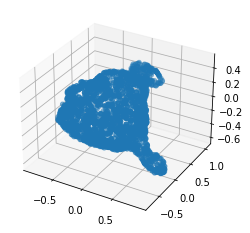

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

number = 1

input_un = all_inputs[number]


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(input_un[:,0], input_un[:,1], input_un[:,2])

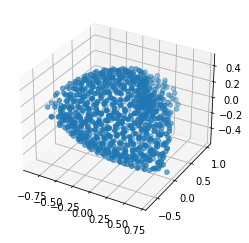

In [12]:
output_un = all_outputs[number]


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(output_un[:,0], output_un[:,1], output_un[:,2])

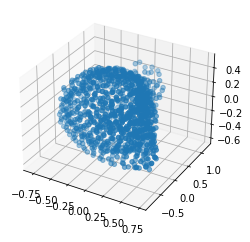

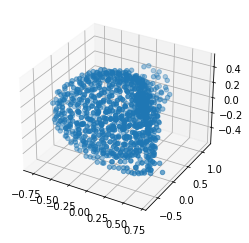

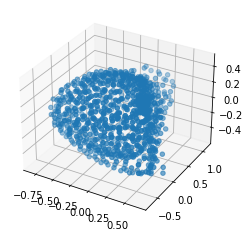

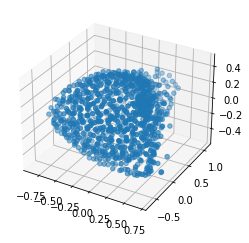

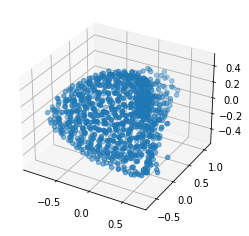

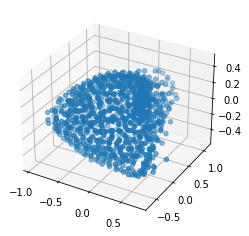

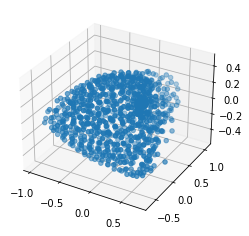

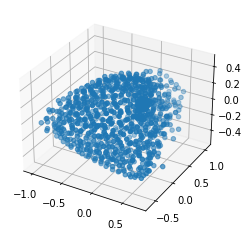

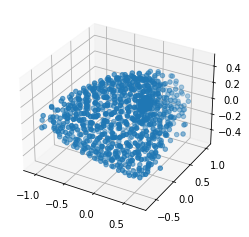

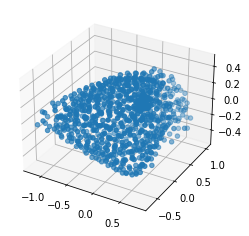

In [11]:
from scipy.stats import norm
# Get the encoded mu and logvar from encode
z = all_z[number]
# want to range the first latent code from [-3, 3]
grid_x = norm.ppf(torch.linspace(0.99, 0.05, 10))


for i in grid_x:
    z[0] = i
    out_un = model._decode(torch.unsqueeze(torch.tensor(z), 0).cuda())
    out_un = torch.squeeze(out_un).detach().cpu().numpy()
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(out_un[:,0], out_un[:,1], out_un[:,2])
    plt.show()
    plt.close()

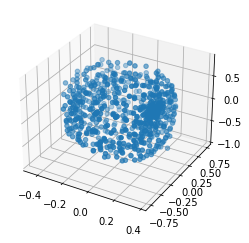

In [12]:
out_un = model._decode(torch.zeros((1,16)).cuda())
out_un = torch.squeeze(out_un).detach().cpu().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(out_un[:,0], out_un[:,1], out_un[:,2])
plt.show()
plt.close()

In [13]:
from torchvision.utils import make_grid

def manifold2d(d: int, **kwargs: Union[str, int]) -> torch.Tensor:
    """
    Plots a learned latent manifold in the image space
    """
    if self.num_classes > 0:
        cls = tt(kwargs.get("label", 0))
        cls = to_onehot(cls.unsqueeze(0), self.num_classes)
    grid_x = norm.ppf(torch.linspace(0.95, 0.05, d))
    grid_y = norm.ppf(torch.linspace(0.05, 0.95, d))
    loc_img_all = []
    for i, xi in enumerate(grid_x):
        for j, yi in enumerate(grid_y):
            z_sample = tt([xi, yi]).float().to(self.device).unsqueeze(0)
            if self.num_classes > 0:
                z_sample = torch.cat([z_sample, cls], dim=-1)
            d_args = (self.grid.unsqueeze(0), z_sample) if self.coord > 0 else (z_sample,)
            loc_img = self.decoder_net(*d_args)
            loc_img_all.append(loc_img.detach().cpu())
    loc_img_all = torch.cat(loc_img_all)

    grid = make_grid(loc_img_all[:, None], nrow=d,
                         padding=kwargs.get("padding", 2),
                         pad_value=kwargs.get("pad_value", 0))
    plt.figure(figsize=(8, 8))
    plt.imshow(grid[0], cmap=kwargs.get("cmap", "gnuplot"),
                   origin=kwargs.get("origin", "upper"),
                   extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18)
    plt.show()

NameError: name 'Union' is not defined

In [14]:
import open3d as o3d

def load_pcd(path):
    pc = o3d.io.read_point_cloud(path)
    ptcloud = np.array(pc.points)
    return ptcloud


def show_points(points, color=None):
    test_pcd = o3d.geometry.PointCloud()
    test_pcd.points = o3d.utility.Vector3dVector(points)
    if color is not None:
        test_pcd.paint_uniform_color(color)
    else:
        test_pcd.paint_uniform_color([1, 0, 0])

    o3d.visualization.draw_geometries([test_pcd], window_name="Open3D2", point_show_normal=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [15]:
pcd = load_pcd("/home/mvries/Documents/Datasets/OPM/" \
               "SingleCellFromNathan_17122021/Plate1/stacked_pointcloud/Binimetinib/" \
               "0010_0011_accelerator_20210315_bakal01_erk_main_21-03-15_12-37-27.ply")

In [23]:
pcdstd = (pcd - pcd.mean(axis=0)) / 20

In [24]:
show_points(pcdstd)

In [32]:
def create_sphere_at_xyz(xyz, colors=None, radius=0.012, resolution=4):
    """create a mesh sphere at xyz
    Args:
        xyz: arr, (3,)
        colors: arr, (3, )
    Returns:
        sphere: mesh sphere
    """
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius, resolution=resolution)
    # sphere.compute_vertex_normals()
    if colors is None:
        sphere.paint_uniform_color([0.7, 0.1, 0.1])  # To be changed to the point color.
    else:
        sphere.paint_uniform_color(colors)
    sphere = sphere.translate(xyz)
    return sphere


def create_pcd_mesh(point_cloud, colors=None):
    """create a mesh spheres for all coordinates in point_cloud
    Args:
        point_cloud: arr, (m, 3)
        colors: arr, (3, )
    Returns:
        mesh_pcd: obj, mesh point cloud
    """
    mesh = []
    for i in range(point_cloud.shape[0]):
        mesh.append(create_sphere_at_xyz(point_cloud[i], colors=colors))

    mesh_pcd = mesh[0]
    for i in range(1, len(mesh)):
        mesh_pcd += mesh[i]
    return mesh_pcd

In [33]:
mesh = create_pcd_mesh(pcdstd)

In [34]:
mesh

TriangleMesh with 53248 points and 98304 triangles.

In [35]:
o3d.visualization.draw_geometries([mesh])

In [36]:
import bpy
import bmesh


ModuleNotFoundError: No module named 'bpy'